In [1]:
from typing import Optional
import numpy as np
import jax.random as jr
import jax
import jax.numpy as jnp
import timeit
import matplotlib.pyplot as plt
import torch

from generator import init_inputs, generate_la, make_net
from fosters_method import mom4_jax
from src.evaluation.evaluation import fourth_moment_errors


def compute_time(
    bm_dim, num_samples, gan_config: Optional[tuple] = None, print_results=True
):
    num_reps = 100
    key = jr.key(0)
    key_net, key_inputs, key_method = jr.split(key, 3)
    w, hh, triu_indices = init_inputs(key_inputs, num_samples, bm_dim, jnp.complex64)
    if gan_config is not None:
        noise_size, hidden_dim, num_layers = gan_config
        slope = 0.01
        net = make_net(
            key_net, noise_size, hidden_dim, num_layers, slope, jnp.complex64
        )
        fun = lambda: generate_la(key_method, net, triu_indices, w, hh)
    else:
        keys_method = jr.split(key_method, num_samples)
        fun = lambda: mom4_jax(keys_method, triu_indices, w, hh, None)

    # without feeding hh
    fun_block = lambda: jax.block_until_ready(fun())
    fun_block()  # warmup
    time = timeit.repeat(fun_block, number=num_reps, repeat=20)  # measure

    # compute mean and stdev
    mean_time = np.mean(time) / num_reps
    stdev_time = np.std(time) / num_reps
    if print_results:
        print(f"Time: {mean_time:.4} ± {stdev_time:.4} seconds")
    return mean_time, stdev_time

In [2]:
# Batch norm makes it about 2x slower
compute_time(4, 2**18, gan_config=(2, 16, 3))

Time: 0.009498 ± 2.358e-05 seconds


(0.009498168476500724, 2.357512603432098e-05)

In [3]:
compute_time(4, 2**18)

Time: 0.0005359 ± 2.248e-05 seconds


(0.0005359206620000805, 2.2479070569807426e-05)

### Varying number of samples
With `noise_size = 4`, `bm_dim = 4`, `hidden_dim = 16`, `num_layers = 3`

Ratio for 1024 samples: 0.7983
Ratio for 2048 samples: 1.441
Ratio for 4096 samples: 1.037
Ratio for 8192 samples: 3.57
Ratio for 16384 samples: 1.624
Ratio for 32768 samples: 1.042
Ratio for 65536 samples: 4.693
Ratio for 131072 samples: 7.455
Ratio for 262144 samples: 6.068
Ratio for 524288 samples: 3.977


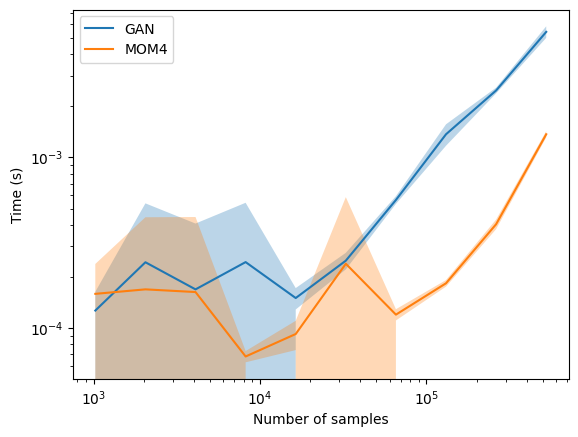

In [17]:
# Plot how the time of both methods changes with the number of samples
# bm_dim = 4, noise_size = 4, hidden_dim = 16, num_layers = 3

num_samples = 2 ** np.arange(10, 20)
times_gan = np.zeros_like(num_samples, dtype=float)
stdevs_gan = np.zeros_like(num_samples, dtype=float)
times_mom4 = np.zeros_like(num_samples, dtype=float)
stdevs_mom4 = np.zeros_like(num_samples, dtype=float)

for i, n in enumerate(num_samples):
    t_gan_mean, t_gan_stdev = compute_time(
        4, n, gan_config=(4, 16, 3), print_results=False
    )
    t_mom4_mean, t_mom4_stdev = compute_time(4, n, print_results=False)
    times_gan[i] = t_gan_mean
    stdevs_gan[i] = t_gan_stdev
    times_mom4[i] = t_mom4_mean
    stdevs_mom4[i] = t_mom4_stdev
    print(f"Ratio for {n} samples: {t_gan_mean/t_mom4_mean:.4}")

plt.figure()
plt.plot(num_samples, times_gan, label="GAN")
plt.fill_between(num_samples, times_gan - stdevs_gan, times_gan + stdevs_gan, alpha=0.3)
plt.plot(num_samples, times_mom4, label="MOM4")
plt.fill_between(
    num_samples, times_mom4 - stdevs_mom4, times_mom4 + stdevs_mom4, alpha=0.3
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of samples")
plt.ylabel("Time (s)")
plt.legend()

### Varying Brownian motion dimension
With `num_samples = 2**15`, `noise_size = 4`, `hidden_dim = 16`, `num_layers = 3`

Ratio for bm_dim=2: 2.027
Ratio for bm_dim=3: 1.704
Ratio for bm_dim=4: 2.565
Ratio for bm_dim=5: 3.343
Ratio for bm_dim=6: 5.917
Ratio for bm_dim=7: 7.893
Ratio for bm_dim=8: 9.215


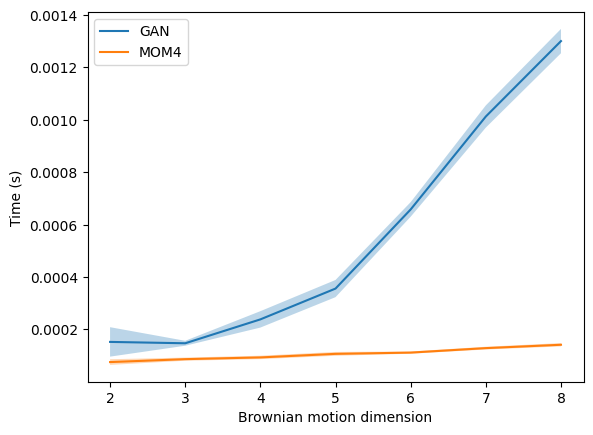

In [4]:
# now do the same thing but vary the bm_dim
# num_samples = 2**15, noise_size = 4, hidden_dim = 16, num_layers = 3

bm_dims = np.arange(2, 9)
times_gan = np.zeros_like(bm_dims, dtype=float)
stdevs_gan = np.zeros_like(bm_dims, dtype=float)
times_mom4 = np.zeros_like(bm_dims, dtype=float)
stdevs_mom4 = np.zeros_like(bm_dims, dtype=float)

for i, bm_dim in enumerate(bm_dims):
    t_gan_mean, t_gan_stdev = compute_time(
        bm_dim, 2**15, gan_config=(4, 16, 3), print_results=False
    )
    t_mom4_mean, t_mom4_stdev = compute_time(bm_dim, 2**15, print_results=False)
    times_gan[i] = t_gan_mean
    stdevs_gan[i] = t_gan_stdev
    times_mom4[i] = t_mom4_mean
    stdevs_mom4[i] = t_mom4_stdev
    print(f"Ratio for bm_dim={bm_dim}: {t_gan_mean/t_mom4_mean:.4}")

plt.figure()
plt.plot(bm_dims, times_gan, label="GAN")
plt.fill_between(bm_dims, times_gan - stdevs_gan, times_gan + stdevs_gan, alpha=0.3)
plt.plot(bm_dims, times_mom4, label="MOM4")
plt.fill_between(bm_dims, times_mom4 - stdevs_mom4, times_mom4 + stdevs_mom4, alpha=0.3)
plt.xlabel("Brownian motion dimension")
plt.ylabel("Time (s)")
plt.legend()

### Varying noise size
With `bm_dim = 4`, `num_samples = 2**15`, `hidden_dim = 16`, `num_layers = 3`

Ratio for noise_size=1: 1.389
Ratio for noise_size=2: 1.364
Ratio for noise_size=3: 1.447
Ratio for noise_size=4: 1.887
Ratio for noise_size=5: 1.953
Ratio for noise_size=6: 2.267
Ratio for noise_size=7: 2.262
Ratio for noise_size=8: 2.774


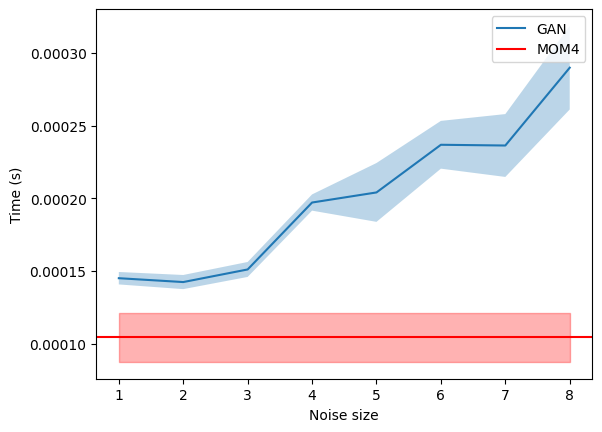

In [10]:
# now do the same thing but vary the noise size
# bm_dim = 4, num_samples = 2**15, hidden_dim = 16, num_layers = 3

ref_time_mom4, ref_stdev_mom4 = compute_time(4, 2**14, print_results=False)

noise_sizes = np.arange(1, 5)
times_gan = np.zeros_like(noise_sizes, dtype=float)
stdevs_gan = np.zeros_like(noise_sizes, dtype=float)

for i, noise_size in enumerate(noise_sizes):
    t_gan_mean, t_gan_stdev = compute_time(
        4, 2**14, gan_config=(noise_size, 16, 3), print_results=False
    )
    times_gan[i] = t_gan_mean
    stdevs_gan[i] = t_gan_stdev
    print(f"Ratio for noise_size={noise_size}: {t_gan_mean/ref_time_mom4:.4}")

plt.figure()
plt.plot(noise_sizes, times_gan, label="GAN")
plt.fill_between(noise_sizes, times_gan - stdevs_gan, times_gan + stdevs_gan, alpha=0.3)
plt.axhline(ref_time_mom4, color="r", label="MOM4")
plt.fill_between(
    noise_sizes,
    ref_time_mom4 - ref_stdev_mom4,
    ref_time_mom4 + ref_stdev_mom4,
    alpha=0.3,
    color="r",
)
plt.xlabel("Noise size")
plt.ylabel("Time (s)")
plt.legend()

### Varying net size
With `noise_size = 4`, `bm_dim = 4`, `num_samples = 2**15`

In [13]:
# Plot how the time of the GAN changes based on number of layers for hidden_dim= 4, 8, 16, or 32

# Draw just a fixed line for the MOM4 method

ref_time_mom4, ref_stdev_mom4 = compute_time(4, 2**14, print_results=False)

num_layers = np.arange(1, 9)
hidden_dims = 2.0 ** np.arange(2, 6)
shape = (len(num_layers), len(hidden_dims))
times_gan = np.zeros(shape, dtype=float)
stdevs_gan = np.zeros(shape, dtype=float)
times_mom4 = np.zeros(shape, dtype=float)
stdevs_mom4 = np.zeros(shape, dtype=float)

for i, n in enumerate(num_layers):
    for j, hidden_dim in enumerate(hidden_dims):
        gan_conf = 1, int(hidden_dim), int(n)
        t_gan_mean, t_gan_stdev = compute_time(
            4, 2**14, gan_config=gan_conf, print_results=False
        )
        times_gan[i, j] = t_gan_mean
        stdevs_gan[i, j] = t_gan_stdev
        print(
            f"Ratio for hidden_dim={hidden_dim}, num_layers={n}: {t_gan_mean/ref_time_mom4:.4}"
        )

Ratio for hidden_dim=4.0, num_layers=1: 1.213
Ratio for hidden_dim=8.0, num_layers=1: 1.148
Ratio for hidden_dim=16.0, num_layers=1: 1.21
Ratio for hidden_dim=32.0, num_layers=1: 1.526
Ratio for hidden_dim=4.0, num_layers=2: 1.203
Ratio for hidden_dim=8.0, num_layers=2: 1.14
Ratio for hidden_dim=16.0, num_layers=2: 1.21
Ratio for hidden_dim=32.0, num_layers=2: 1.466
Ratio for hidden_dim=4.0, num_layers=3: 1.257
Ratio for hidden_dim=8.0, num_layers=3: 1.184
Ratio for hidden_dim=16.0, num_layers=3: 1.262
Ratio for hidden_dim=32.0, num_layers=3: 1.666
Ratio for hidden_dim=4.0, num_layers=4: 1.292
Ratio for hidden_dim=8.0, num_layers=4: 1.241
Ratio for hidden_dim=16.0, num_layers=4: 1.343
Ratio for hidden_dim=32.0, num_layers=4: 1.946
Ratio for hidden_dim=4.0, num_layers=5: 1.363
Ratio for hidden_dim=8.0, num_layers=5: 1.318
Ratio for hidden_dim=16.0, num_layers=5: 1.444
Ratio for hidden_dim=32.0, num_layers=5: 2.191
Ratio for hidden_dim=4.0, num_layers=6: 1.462
Ratio for hidden_dim=8.0, n

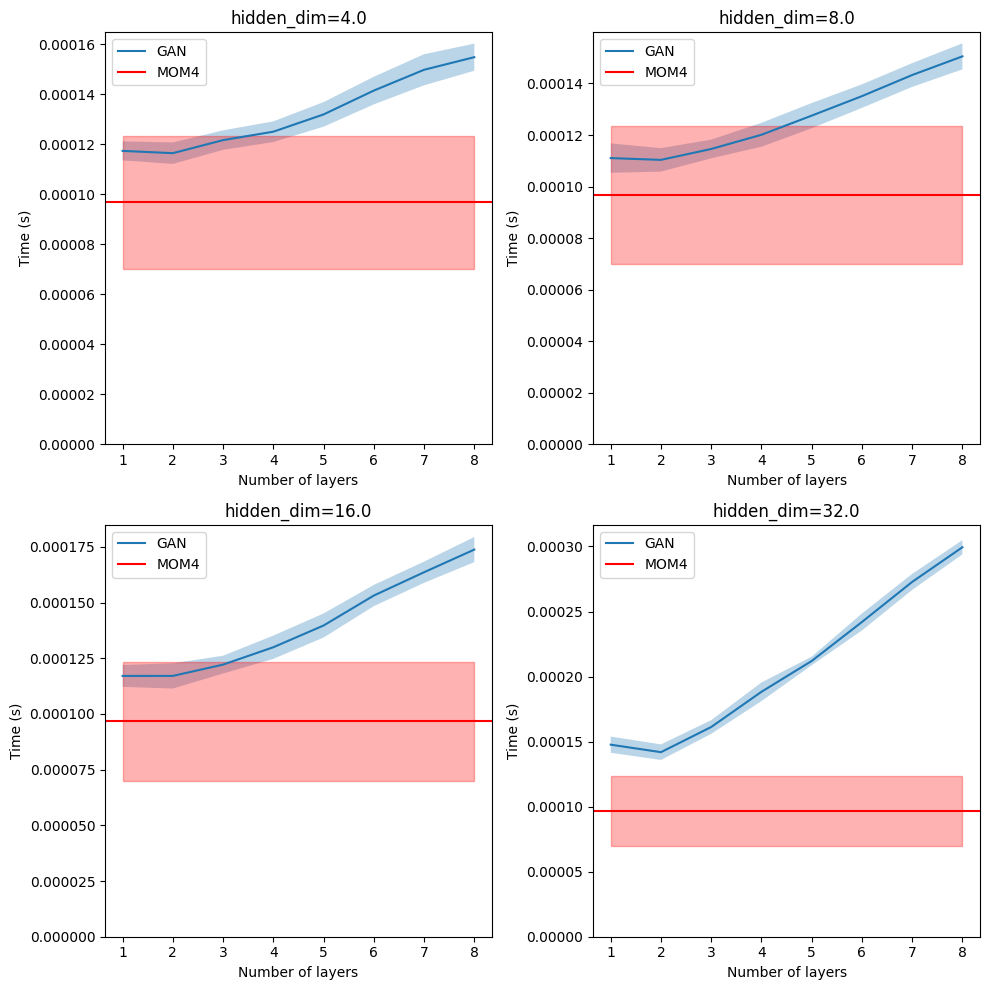

In [14]:
# Plot for each value of hidden_dim in a separate subfigure
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    ax.plot(num_layers, times_gan[:, i], label="GAN")
    ax.fill_between(
        num_layers,
        times_gan[:, i] - stdevs_gan[:, i],
        times_gan[:, i] + stdevs_gan[:, i],
        alpha=0.3,
    )
    ax.axhline(ref_time_mom4, color="r", label="MOM4")
    ax.fill_between(
        num_layers,
        ref_time_mom4 - ref_stdev_mom4,
        ref_time_mom4 + ref_stdev_mom4,
        alpha=0.3,
        color="r",
    )
    ax.set_title(f"hidden_dim={hidden_dims[i]}")
    ax.set_xlabel("Number of layers")
    ax.set_ylabel("Time (s)")
    ax.set_ylim(bottom=0)
    ax.legend()
plt.tight_layout()
plt.show()

### Check that Foster's method works correctly

In [2]:
def load_moments(bm_dim):
    file_path = f"/home/andy/PycharmProjects/Levy_CFGAN/moments/dim_{bm_dim}_moments.pt"
    moments_loaded = torch.load(file_path)
    return moments_loaded


true_fourth_moments = load_moments(6)

In [3]:
w, hh, triu_indices = init_inputs(jr.key(4), 2**20, 6, jnp.float32)
keys = jr.split(jr.key(5), 2**20)
_, _, _, foster_samples = mom4_jax(keys, triu_indices, w, hh, None)
print(jnp.mean(foster_samples, axis=0))
print(jnp.var(foster_samples, axis=0))
foster_samples_torch = torch.tensor(np.array(foster_samples))
errs_mean, errs_rms, errs_max = fourth_moment_errors(
    foster_samples_torch, true_fourth_moments, loss_type="all"
)
print(
    f"Max error: {float(errs_max):.4}, RMS error: {float(errs_rms):.4}, Mean error: {float(errs_mean):.4}"
)

[-4.1762448e-04 -1.2919579e-04 -2.8724014e-04  2.3840679e-04
 -1.6135784e-04 -4.1532709e-04  5.6839781e-04 -2.2840717e-04
 -3.3115345e-04  2.4414249e-04 -6.6476699e-05  4.8069929e-04
  2.1617887e-04  4.3119371e-04 -8.8069617e-05]
[0.2495167  0.25007817 0.25016105 0.24958596 0.24955326 0.24984653
 0.2503457  0.25029278 0.25009298 0.25060478 0.25069758 0.2499277
 0.2503903  0.25006917 0.24959804]
Max error: 0.003567, RMS error: 0.0003624, Mean error: 0.000221
